In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import string
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
#nltk.download('stopwords')
#nltk.download('punkt')

In [35]:
df = pd.read_csv('ea_forum/data/ea_forum/cleaned_data_eaforum.csv', parse_dates=['date'], index_col='date')
df.sort_index(inplace=True)
df['date'] = df.index.copy()
df['month-year'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')
df

,Unnamed: 0,title,author,num_comments,num_karma,content,date,month-year
date,,,,,,,,
2013-01-22,18,Replaceability,Paul_Christiano,0,1,Suppose I am trying to evaluate the consequenc...,2013-01-22,2013-01
2013-02-27,31,"To save the world, don’t get a job at a charit...",William_MacAskill,5,2,Few people think of finance as an ethical c...,2013-02-27,2013-02
2013-02-27,44,Why might the future be good?,Paul_Christiano,0,1,"When talking about the future, I often encount...",2013-02-27,2013-02
2013-02-28,21,Risk aversion and investment (for altruists),Paul_Christiano,6,3,Suppose I hope to use my money to do good some...,2013-02-28,2013-02
2013-03-12,63,Giving now vs. later,Paul_Christiano,0,0,It has been observed that money spent helping ...,2013-03-12,2013-03
...,...,...,...,...,...,...,...,...
2020-04-13,397,EA Forum Downtime Monday April 13th 9:30pm PDT,JP Addison,3,7,Edit: This is done.The EA Forum will be down f...,2020-04-13,2020-04
2020-04-13,47,[Notes] Climate Shock by Wagner and Weitzman,Louis_Dixon,1,23,"IntroductionContextOver the past year, several...",2020-04-13,2020-04
2020-04-14,27,The Case for Impact Purchase | Part 1,Linda Linsefors,35,50,In this post I will argue for impact purchase ...,2020-04-14,2020-04


In [36]:
### data cleaning

In [37]:
# check for missing data
df.isnull().sum() # 7 posts with no content
df.loc[df.isnull().values] # in 2019/20
df.dropna(inplace=True)

In [38]:
# lowercase
df['cleaned'] = df['content'].str.lower()

# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("", "", string.punctuation + '“')) # str.translate method
df['cleaned'] = df['cleaned'].apply(remove_punctuation)
# also have '“' in text, but not in string.punctuation

# remove prefixes: 'in', 'un', 'non'
    # stemming treats 'intractable' and 'tractable' differently, so need to remove prefixes
prefixes = ['in', 'un', 'non']
def remove_prefix(word):
    for prefix in prefixes:
        if word.startswith(prefix):
            word = word[len(prefix):]
            break # don't need to check other prefixes
    return word

df['cleaned'] = df['cleaned'].apply(lambda x: " ".join(remove_prefix(word) for word in x.split()))

# remove stopwords ('the', 'is', 'and', etc)
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])
df['cleaned'] = df['cleaned'].apply(remove_stopwords)

In [39]:
# tokenize and stem
ps = PorterStemmer()
    # based on suffix stripping

def stem_text(text):
    tokens = word_tokenize(text)
    return " ".join([ps.stem(word) for word in tokens])
    # output is a string, not a list

df['stemmed'] = df['cleaned'].apply(stem_text) # takes a minute

In [40]:
# testing 
word_variants = ['importance', 'important', 'importantly','neglected', 'neglectedness', 'tractable', 'tractability', 'intractable', 'scale', 'scalability', 'solve', 'solvable', 'solvability', 'crowdedness', 'crowded', 'uncrowded']

{w: (w) for w in word_variants}

# 'neglectedness': 'neglected'
    # so need to combine with 'neglected'
# 'importantly': 'importantli'
  # so 'importantly' won't get lumped together with 'importance'


{'importance': 'import',
 'important': 'import',
 'importantly': 'importantli',
 'neglected': 'neglect',
 'neglectedness': 'neglected',
 'tractable': 'tractabl',
 'tractability': 'tractabl',
 'intractable': 'intract',
 'scale': 'scale',
 'scalability': 'scalabl',
 'solve': 'solv',
 'solvable': 'solvabl',
 'solvability': 'solvabl',
 'crowdedness': 'crowded',
 'crowded': 'crowd',
 'uncrowded': 'uncrowd'}

In [84]:
itn_words = ['importance', 'tractable', 'neglected', 'neglectedness']
itn_stem = [ps.stem(x) for x in itn_words] # import, tractabl, neglect, neglected

df['i_count'] = df['stemmed'].str.count(itn_stem[0])
df['t_count'] = df['stemmed'].str.count(itn_stem[1]) 
df['n_count'] = df['stemmed'].str.count(itn_stem[2]) + df['stemmed'].str.count(itn_stem[3])

df['i_rate'] = df['i_count']*1e6 / df['stemmed'].str.len()
df['t_rate'] = df['t_count']*1e6 / df['stemmed'].str.len()
df['n_rate'] = df['n_count']*1e6 / df['stemmed'].str.len()
# rate per million words
    # rescaling, multiply by 1e6 (excluding stop words, etc)

In [43]:
print('importance:', 'total count:', df['i_count'].sum(), ', average:', df['i_rate'].mean())
print('tractable:', 'total count:', df['t_count'].sum(), ', average:', df['t_rate'].mean())
print('neglected:', 'total count:', df['n_count'].sum(), ', average:', df['n_rate'].mean())

importance: total count: 6102 , average: 320.99763177319676
tractable: total count: 827 , average: 38.87246714979104
neglected: total count: 1819 , average: 90.72205396155324


array([[<AxesSubplot:title={'center':'t_count'}>,
        <AxesSubplot:title={'center':'i_count'}>],
       [<AxesSubplot:title={'center':'n_count'}>, <AxesSubplot:>]],
      dtype=object)

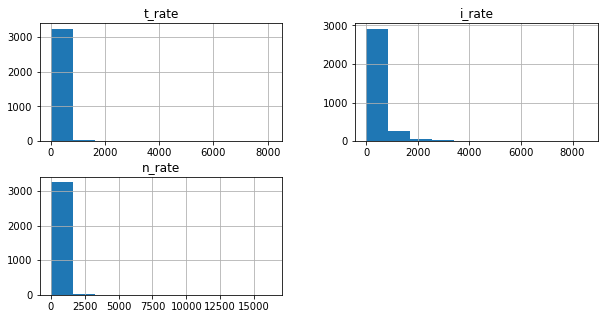

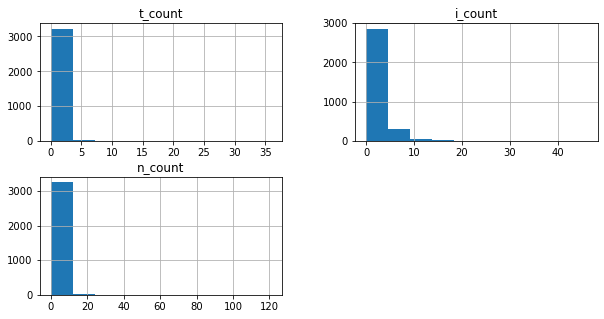

In [44]:
# histograms
df[['t_rate', 'i_rate', 'n_rate']].hist(figsize=(10,5))
df[['t_count', 'i_count', 'n_count']].hist(figsize=(10,5))
# pretty skewed

<AxesSubplot:xlabel='date'>

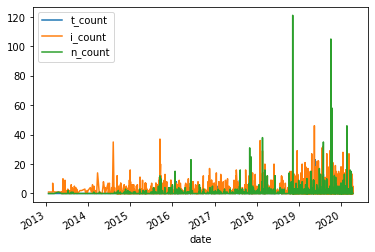

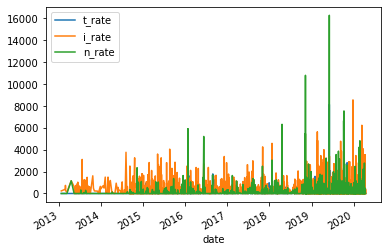

In [45]:
# post-level graphs
df[['t_count', 'i_count', 'n_count']].plot()
df[['t_rate', 'i_rate', 'n_rate']].plot()

<AxesSubplot:xlabel='date'>

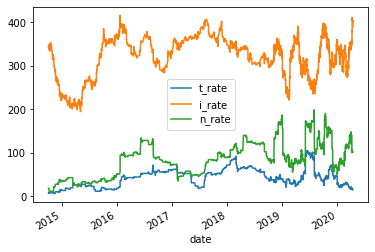

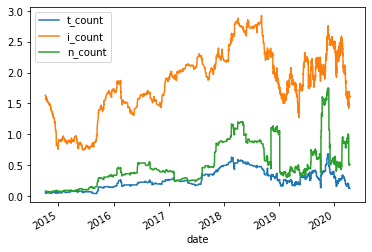

In [82]:
# rolling average
# df_rolling = df[['t_rate', 'i_rate', 'n_rate', 't_count', 'i_count', 'n_count']].rolling(window=300).mean()
df_rolling = df[['t_rate', 'i_rate', 'n_rate', 't_count', 'i_count', 'n_count']].rolling(window=180).mean()
# df_rolling = df[['t_rate', 'i_rate', 'n_rate', 't_count', 'i_count', 'n_count']].rolling(window=60).mean()
df_rolling[['t_rate', 'i_rate', 'n_rate']].plot()
df_rolling[['t_count', 'i_count', 'n_count']].plot()
# super noisy

<AxesSubplot:xlabel='date'>

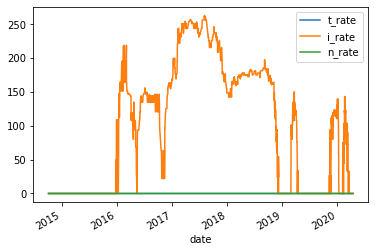

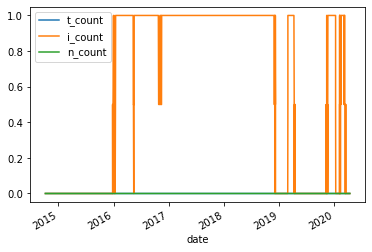

In [48]:
# rolling median
df_rolling_med = df[['t_rate', 'i_rate', 'n_rate', 't_count', 'i_count', 'n_count']].rolling(window=180).median()
df_rolling_med[['t_rate', 'i_rate', 'n_rate']].plot()
df_rolling_med[['t_count', 'i_count', 'n_count']].plot()
# also super noisy, get 0s for T,N

<AxesSubplot:xlabel='date'>

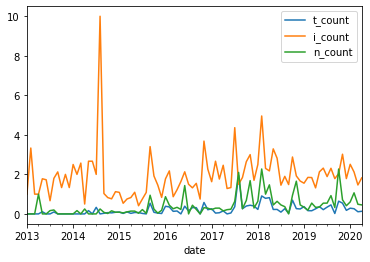

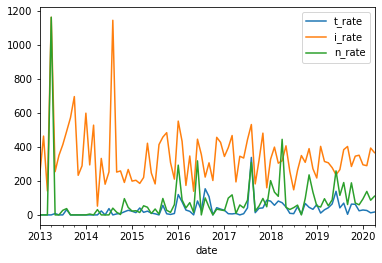

In [67]:
# average by month
df_my = df.resample('M').mean()
df_my[['t_count', 'i_count', 'n_count']].plot()
df_my[['t_rate', 'i_rate', 'n_rate']].plot()

# not horrible, but still outliers

<AxesSubplot:xlabel='date'>

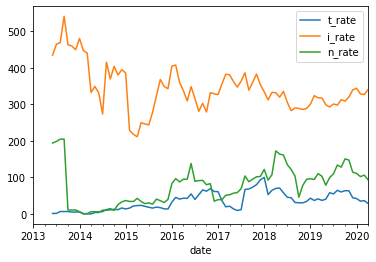

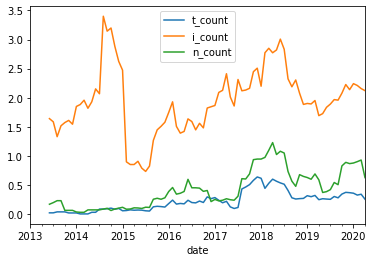

In [88]:
# monthly rolling average
df_my_rolling = df_my[['t_rate', 'i_rate', 'n_rate', 't_count', 'i_count', 'n_count']].rolling(window=6).mean()
df_my_rolling[['t_rate', 'i_rate', 'n_rate']].plot()
df_my_rolling[['t_count', 'i_count', 'n_count']].plot()


In [64]:
df_my.loc['2013']
# only four months have posts in 2013

,Unnamed: 0,num_comments,num_karma,i_count,t_count,n_count,i_rate,t_rate,n_rate
date,,,,,,,,,
2013-03-31,35.400000,2.200000,1.400000,2.400000,0.000000,0.000000,353.021141,0.000000,0.000000
2013-06-30,30.238095,2.142857,4.380952,1.714286,0.047619,0.047619,347.824320,3.482197,55.370986
2013-09-30,33.233333,1.300000,3.000000,1.433333,0.033333,0.133333,481.645818,10.358401,23.207778
2013-12-31,33.600000,7.700000,2.100000,1.400000,0.000000,0.000000,405.350541,0.000000,0.000000


In [85]:
df_my.loc['2014']

,Unnamed: 0,num_comments,num_karma,i_count,t_count,n_count,i_rate,t_rate,n_rate
date,,,,,,,,,
2014-01-31,159.000000,2.500000,1.000000,2.500000,0.000000,0.000000,598.528031,0.000000,0.000000
2014-02-28,143.666667,0.833333,4.500000,2.000000,0.000000,0.166667,294.141962,0.000000,5.130889
2014-03-31,153.000000,3.000000,4.000000,2.571429,0.000000,0.000000,528.084611,0.000000,0.000000
2014-04-30,144.500000,7.250000,3.000000,0.500000,0.000000,0.250000,51.581815,0.000000,31.250000
2014-05-31,140.666667,3.666667,2.500000,2.666667,0.166667,0.000000,332.292576,23.391813,0.000000
2014-06-30,124.666667,17.666667,3.000000,2.666667,0.000000,0.000000,180.539722,0.000000,0.000000
2014-07-31,132.833333,1.166667,2.833333,2.000000,0.333333,0.000000,252.998682,37.252272,0.000000
2014-08-31,114.500000,4.750000,4.250000,10.000000,0.000000,0.250000,1144.950366,0.000000,39.846988
2014-09-30,108.650794,12.222222,7.507937,1.031746,0.031746,0.079365,251.987353,6.026580,15.761345


In [56]:
# 'importance'/'neglectedness' outliers in 2013-04
print(df.loc['2013-04-01':'2013-05-01',:]['stemmed'].str.len())
print(1e6/df.loc['2013-04-01':'2013-05-01',:]['stemmed'].str.len())
df.loc['2013-04-01':'2013-05-01',:]

# single post with len=860, i_count = n_count = 1
# 1e6/860 = 1162

date
2013-04-18    860
Name: stemmed, dtype: int64
date
2013-04-18    1162.790698
Name: stemmed, dtype: float64


,Unnamed: 0,title,author,num_comments,num_karma,content,date,month-year,cleaned,stemmed,i_count,t_count,n_count,i_rate,t_rate,n_rate
date,,,,,,,,,,,,,,,,
2013-04-18,58,Doing well by doing good: careers that benefit...,William_MacAskill,0,0,To what extent do self-interest and altruism c...,2013-04-18,2013-04,extent selfinterest altruism conflict latest q...,extent selfinterest altruism conflict latest q...,1,0,1,1162.790698,0.0,1162.790698


In [86]:
# 'importance' outlier in 2014-08
print(df.loc['2014-08-01':'2014-09-01',:]['stemmed'].str.len())
print(1e6*df.loc['2014-08-01':'2014-09-01',:]['i_count']/df.loc['2014-08-01':'2014-09-01',:]['stemmed'].str.len())
df.loc['2014-08-01':'2014-09-01',:]

# one post with len=9000, i_count 35
# i_rate 3700

date
2014-08-06    9298
2014-08-13    3519
2014-08-18    6274
2014-08-21    5618
2014-09-01    1865
Name: stemmed, dtype: int64
date
2014-08-06    3764.250376
2014-08-13       0.000000
2014-08-18     637.551801
2014-08-21     177.999288
2014-09-01       0.000000
dtype: float64


,Unnamed: 0,title,author,num_comments,num_karma,content,date,month-year,cleaned,stemmed,i_count,t_count,n_count,i_rate,t_rate,n_rate
date,,,,,,,,,,,,,,,,
2014-08-06,85,A relatively atheoretical perspective on astro...,Nick_Beckstead,8,7,Crossposted from the Global Priorities Project...,2014-08-06,2014-08,crossposted global priorities project troducti...,crosspost global prioriti project troduct comm...,35,0,0,3764.250376,0.0,0.00000
2014-08-13,130,Strategic considerations about different speed...,Owen_Cotton-Barratt,4,3,Crossposted from the Global Priorities Project...,2014-08-13,2014-08,crossposted global priorities projectcowritten...,crosspost global prioriti projectcowritten owe...,0,0,0,0.000000,0.0,0.00000
2014-08-18,139,"Conversation with Holden Karnofsky, Nick Becks...",Nick_Beckstead,7,2,"Earlier this year, I had an email conversation...",2014-08-18,2014-08,earlier year email conversation holden karnofs...,earlier year email convers holden karnofski el...,4,0,1,637.551801,0.0,159.38795
2014-08-21,104,Why we should err in both directions,Owen_Cotton-Barratt,0,5,Crossposted from the Global Priorities Project...,2014-08-21,2014-08,crossposted global priorities project troducti...,crosspost global prioriti project troduct prin...,1,0,0,177.999288,0.0,0.00000
2014-09-01,111,Superintelligence reading group,Katja_Grace,1,5,Are you curious about risks from artificial in...,2014-09-01,2014-09,curious risks artificial telligence want find ...,curiou risk artifici tellig want find whether ...,0,0,0,0.000000,0.0,0.00000


<AxesSubplot:xlabel='date'>

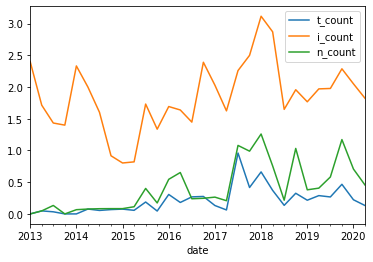

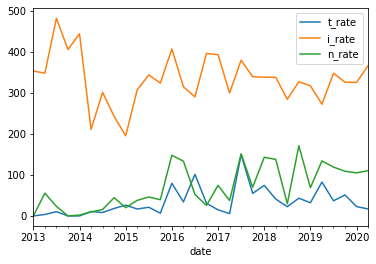

In [87]:
# average by quarter
df_qy = df.resample('Q').mean()
df_qy[['t_count', 'i_count', 'n_count']].plot()
df_qy[['t_rate', 'i_rate', 'n_rate']].plot()

# smoother

<AxesSubplot:xlabel='date'>

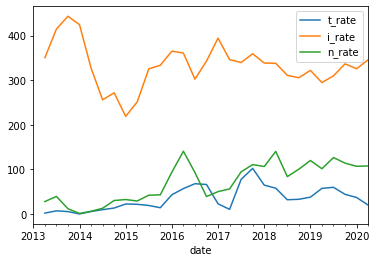

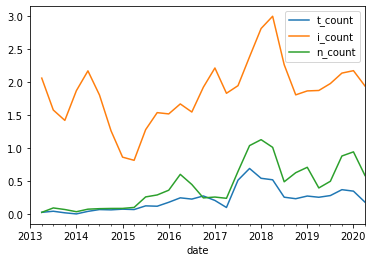

In [90]:
# quarterly rolling average
df_qy_rolling = df_qy[['t_rate', 'i_rate', 'n_rate', 't_count', 'i_count', 'n_count']].rolling(window=2).mean()
df_qy_rolling[['t_rate', 'i_rate', 'n_rate']].plot()
df_qy_rolling[['t_count', 'i_count', 'n_count']].plot()


In [ ]:
# takeaways:
# as expected (because it has more uses in everyday language), 'importance' has the most mentions
# 'tractability' and 'neglectedness' are roughly similar, but 'neglectedness' seems to be used more